In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import re
import time
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import textwrap
import scipy.stats as stats

from scipy import stats
import scipy
from functools import partial

import matplotlib.pylab as pylab
import seaborn as sns
sns.set_style('whitegrid', {'legend.frameon':True})
sns.set_palette(sns.color_palette("Set1", 12))
#sns.set_context("paper")
fontsize = 12
params = {
    'legend.fontsize': fontsize,
    'figure.figsize': (6.7, 5),
    'figure.dpi': 200,
    'axes.labelsize': fontsize,
    'axes.titlesize':fontsize,
    'axes.edgecolor':"0.3",
    'xtick.labelsize':fontsize,
    'ytick.labelsize':fontsize,
    'legend.fontsize':10,
    'font.size':fontsize,
    'font.family':'serif',
    'figure.facecolor': 'white',
    'savefig.facecolor': 'white'
}
pylab.rcParams.update(params)
plt.rc('axes', labelsize=fontsize) 

#plt.style.use('ggplot')
%matplotlib inline

from tqdm.notebook import tqdm
import pandas as pd
from pathlib2 import Path
import os

In [2]:
import sys
sys.path.append('../')

from metric_store import save_metrics, save_metric, load_metrics, get_metric_names, load_metric
from network_metrics import prepare_metric
from pipeline.pipeline import load_config

In [32]:
metric_prefix = 'lgm_deviation_for_cyclones'
metric_image_dir = 'max_deviation_region'

In [3]:
metric_prefix = 'lgm_metric_in_track_for_cyclones'
metric_image_dir = 'metric_in_region'

In [22]:
metric_prefix = 'lgm_metric_in_track_for_cyclones_shifted'
metric_image_dir = 'shifted_metric_in_region'

In [27]:
config_name = "pipeline.config"
config = load_config(config_name)
work_dir = config.download_ERA5_options['work_dir']
delay = str(config.correlations['delay_time'] * config.download_ERA5_options['step_time']) + "h"
window = str(config.correlations['window_size'] * config.download_ERA5_options['step_time']) + "h"
is_sond = True
image_dir = work_dir / 'results_histogram' / '_'.join([
    metric_image_dir, 
    'delay', delay, 
    'window', window, 
    'time', 'sond' if is_sond else 'all'
])
image_dir.mkdir(parents=True, exist_ok=True)
print(image_dir)
print(delay)

Z:\Research\Climate\data\ERA5\ERA5_MSL_1982_2020_3h_0.75\results_histogram\metric_in_region_delay_0h_window_48h_time_sond
0h


In [28]:
config

<module 'pipeline.config' from 'd:\\PC\\UNN\\Science\\Climate\\programs\\climate-networks\\src\\notebooks\\..\\pipeline\\config.py'>

In [29]:
metric_names = list(get_metric_names(config, prefix = metric_prefix).keys())
metric_names

['lgm_metric_in_track_for_cyclones/track_size_2/probability_for_metrics/network_metrics/LCC_w',
 'lgm_metric_in_track_for_cyclones/track_size_4/probability_for_metrics/network_metrics/LCC_w',
 'lgm_metric_in_track_for_cyclones/track_size_6/probability_for_metrics/network_metrics/LCC_w',
 'lgm_metric_in_track_for_cyclones/track_size_8/probability_for_metrics/network_metrics/LCC_w',
 'lgm_metric_in_track_for_cyclones/track_size_10/probability_for_metrics/network_metrics/LCC_w',
 'lgm_metric_in_track_for_cyclones/track_size_12/probability_for_metrics/network_metrics/LCC_w',
 'lgm_metric_in_track_for_cyclones/track_size_2/probability_for_metrics/network_metrics/degree_w',
 'lgm_metric_in_track_for_cyclones/track_size_4/probability_for_metrics/network_metrics/degree_w',
 'lgm_metric_in_track_for_cyclones/track_size_6/probability_for_metrics/network_metrics/degree_w',
 'lgm_metric_in_track_for_cyclones/track_size_8/probability_for_metrics/network_metrics/degree_w',
 'lgm_metric_in_track_for_

In [30]:
def load_cyclone_lgm_deviations(metric_names, track_size, is_sond=False):
    cyclone_lgm_deviations_metric_values = {}
    config.metrics_plot_options['track_size'] = track_size
    print(config.metrics_plot_options['track_size'])
    for metric_name in metric_names:
        if not f'track_size_{track_size}' in metric_name:
            continue
        if is_sond ^ (metric_name.find('sond') != -1):
            continue

        config.metrics_plot_options['metric_name'] = metric_name
        metric = load_metric(config, metric_name).item()
        cyclone_lgm_deviations_metric_all = []
        for cyclone_name, cyclone_lgm_deviations in metric.items():
            #print('Cyclone start')
            #print(cyclone_lgm_deviations['metrics'])
            cyclone_lgm_deviations_metric = []
            for cur in cyclone_lgm_deviations['metrics']:
                cyclone_lgm_deviations_metric += np.array(cur).flatten().tolist()
            cyclone_lgm_deviations_metric = np.array(cyclone_lgm_deviations_metric)
            
            #print('Cyclone flatten')
            #print(cyclone_lgm_deviations_metric)
            #print('Cyclone finish')
            cyclone_lgm_deviations_metric = cyclone_lgm_deviations_metric[~np.isnan(cyclone_lgm_deviations_metric)]
            cyclone_lgm_deviations_metric_all += [cyclone_lgm_deviations_metric]
        cyclone_lgm_deviations_metric_all = np.concatenate(cyclone_lgm_deviations_metric_all)
        cyclone_lgm_deviations_metric_values[metric_name] = cyclone_lgm_deviations_metric_all
    return cyclone_lgm_deviations_metric_values

In [24]:
cyclone_lgm_deviations_metric_values_1 = load_cyclone_lgm_deviations(metric_names, track_size=2)
cyclone_lgm_deviations_metric_values_4 = load_cyclone_lgm_deviations(metric_names, track_size=8)

2


In [15]:
cyclone_lgm_deviations_metric_values_tmp = load_cyclone_lgm_deviations(metric_names, track_size=12)

12


In [29]:
print(cyclone_lgm_deviations_metric_values_1['lgm_deviation_for_cyclones/track_size_2/probability_for_metrics/network_metrics/LCC_w'])
print(cyclone_lgm_deviations_metric_values_4['lgm_deviation_for_cyclones/track_size_8/probability_for_metrics/network_metrics/LCC_w'])

KeyError: 'lgm_deviation_for_cyclones/track_size_2/probability_for_metrics/network_metrics/LCC_w'

In [46]:
def plot_hist_metric(metric, metric_name, fig=None):
    if fig is None:
        fig=plt.figure(dpi=300)
    sns.kdeplot(metric, label=metric_name, cut=0)
    from textwrap import wrap
    
    metric_name = 'delay ' + delay + ' / ' + metric_name
    xlabel = "\n".join(wrap(metric_name.replace('$', ' ').replace('/', ' '), width=50)).replace(' ', ' / ').replace('_', ' ')
    xlabel += "\n" * (3 - xlabel.count('\n'))
    plt.xlabel(xlabel)
    plt.xlim([0, 1])
    plt.ylim([0, 12])

# All metrics histogram plot

In [47]:
for track_size in config.g_test_options['track_sizes']:
    cyclone_lgm_deviations_metric_values = load_cyclone_lgm_deviations(metric_names, track_size, is_sond=is_sond)
    for metric_name, cyclone_lgm_deviations in cyclone_lgm_deviations_metric_values.items():
        metric_name = metric_name.split('/')
        main_metric_name = metric_name[1] + '/' + "$".join(metric_name[:1] + metric_name[2:])
        plot_hist_metric(cyclone_lgm_deviations, main_metric_name)
        file_name = image_dir / (main_metric_name + '.png')
        file_name.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(file_name, bbox_inches='tight')
        plt.close()

2
4


In [33]:
config.g_test_options['track_sizes']

[2, 4]

# LCC comparison

In [48]:
for track_size in config.g_test_options['track_sizes']:
    cyclone_lgm_deviations_metric_values = load_cyclone_lgm_deviations(metric_names, track_size, is_sond=is_sond)
    fig = plt.figure(dpi=300)
    for metric_name, cyclone_lgm_deviations in cyclone_lgm_deviations_metric_values.items():
        if metric_name.endswith('probability_for_metrics/network_metrics/LCC_w'):
            plot_hist_metric(cyclone_lgm_deviations, 'LCC_w', fig=fig)
        if metric_name.endswith('probability_for_metrics/network_metrics/LCC_0.95'):
            plot_hist_metric(cyclone_lgm_deviations, 'LCC_0.95', fig=fig)
    
    plt.legend()
    plt.xlabel('Probability')
    
    file_name = image_dir / (f'LCC_w_vs_LCC_0.95_track_size_{track_size}' + '.png')
    file_name.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(file_name, bbox_inches='tight')
    plt.close()

2
4


In [51]:
def filter_shifted(cyclone_lgm_deviations_metric_values, is_shifted=False):
    return {k: x for k, x in cyclone_lgm_deviations_metric_values.items() if is_shifted ^ (not 'shifted' in k)}
    

# Compare all metrics on violinplot

2
4


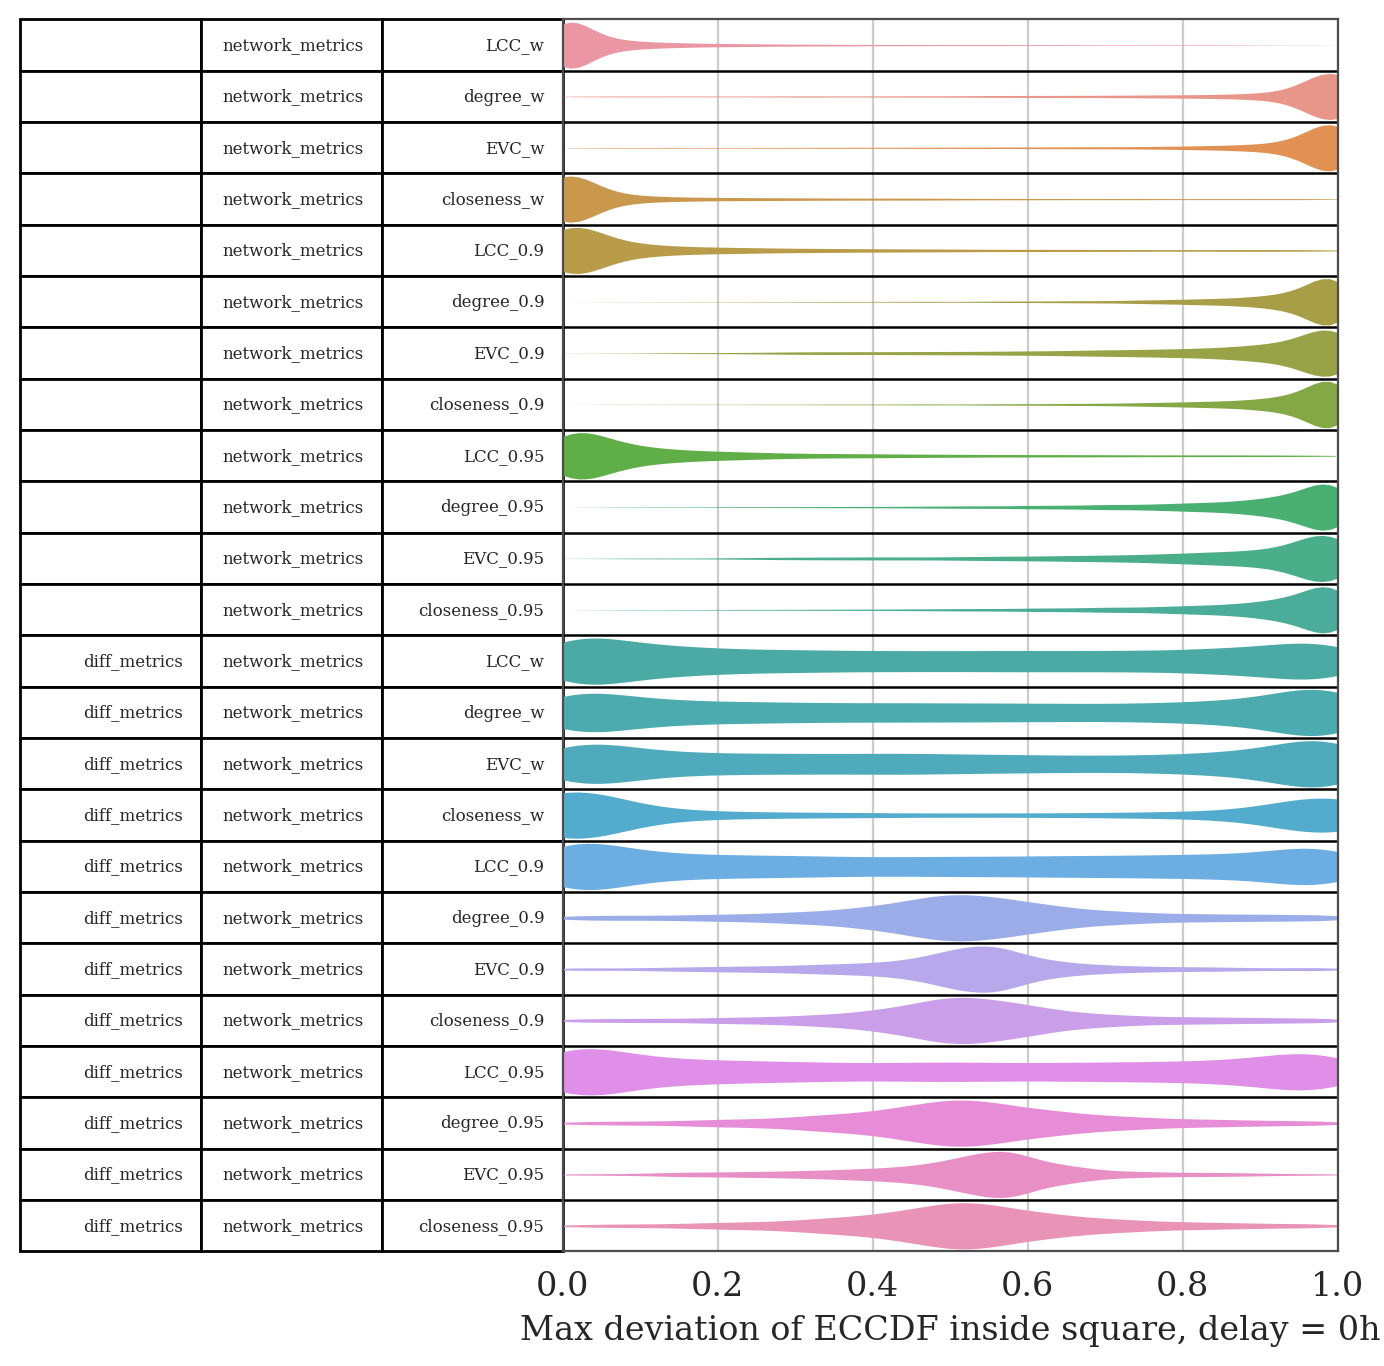

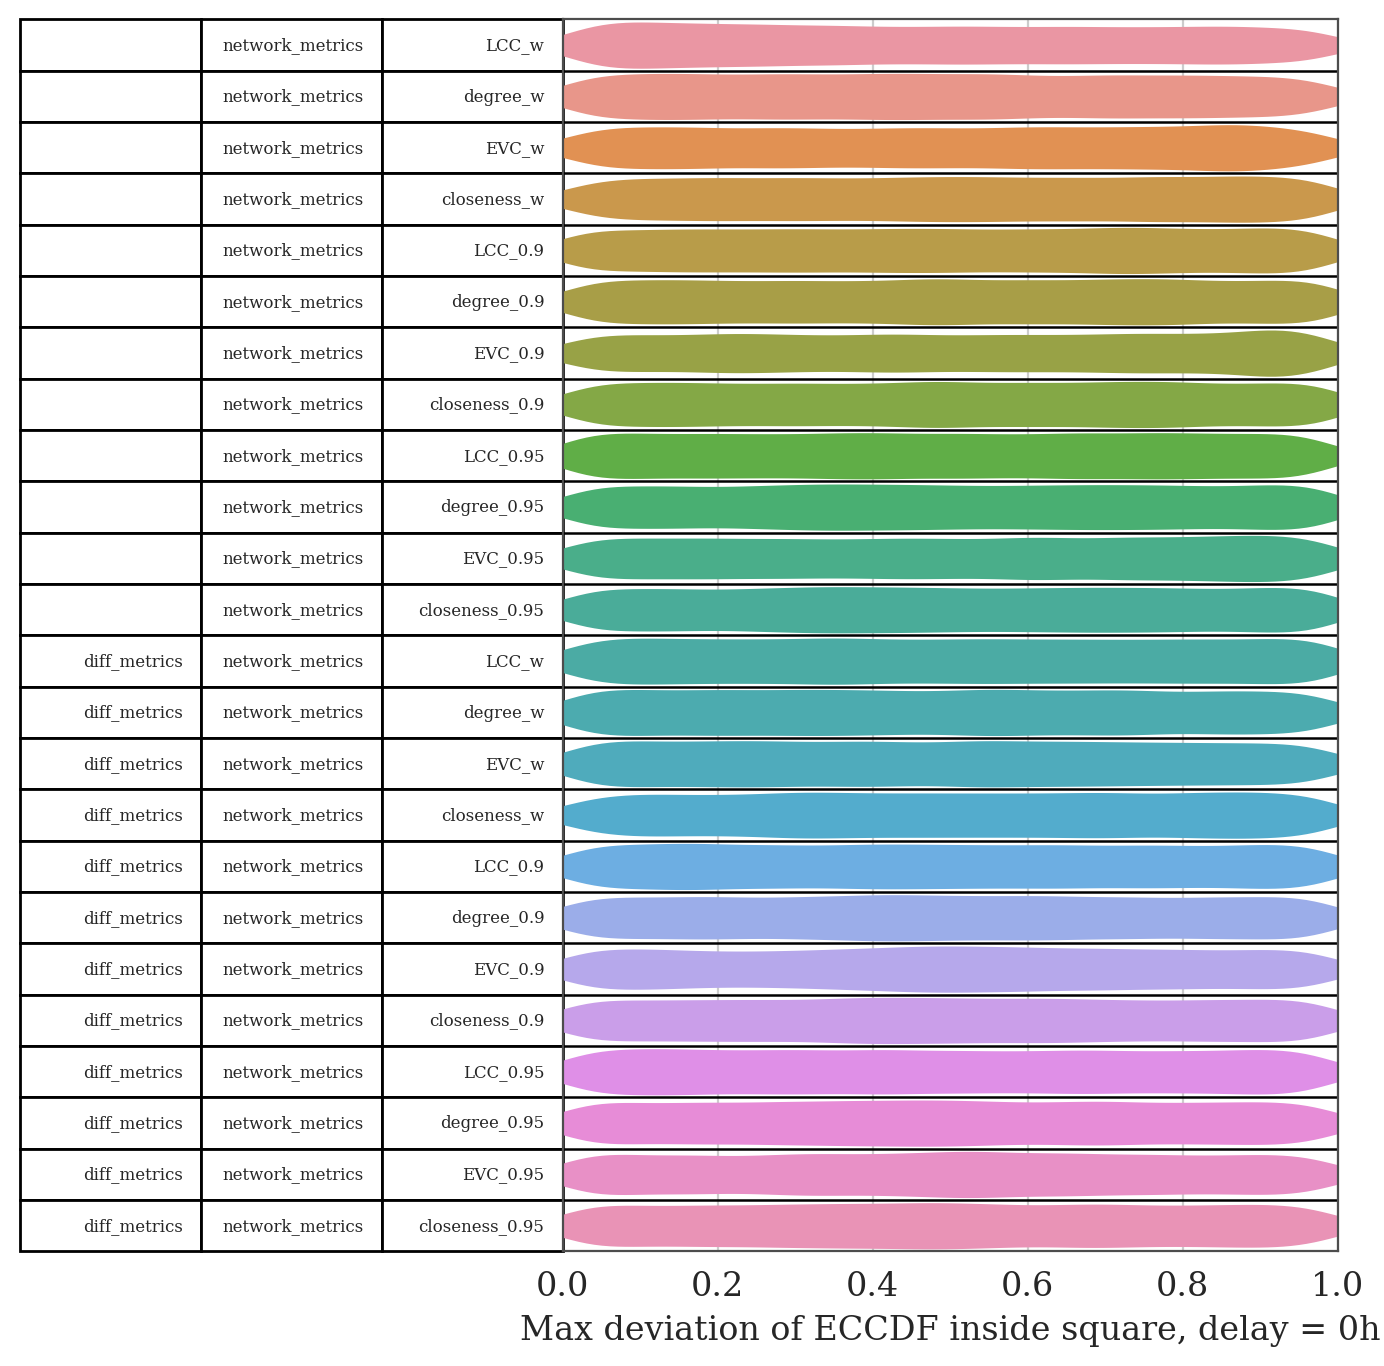

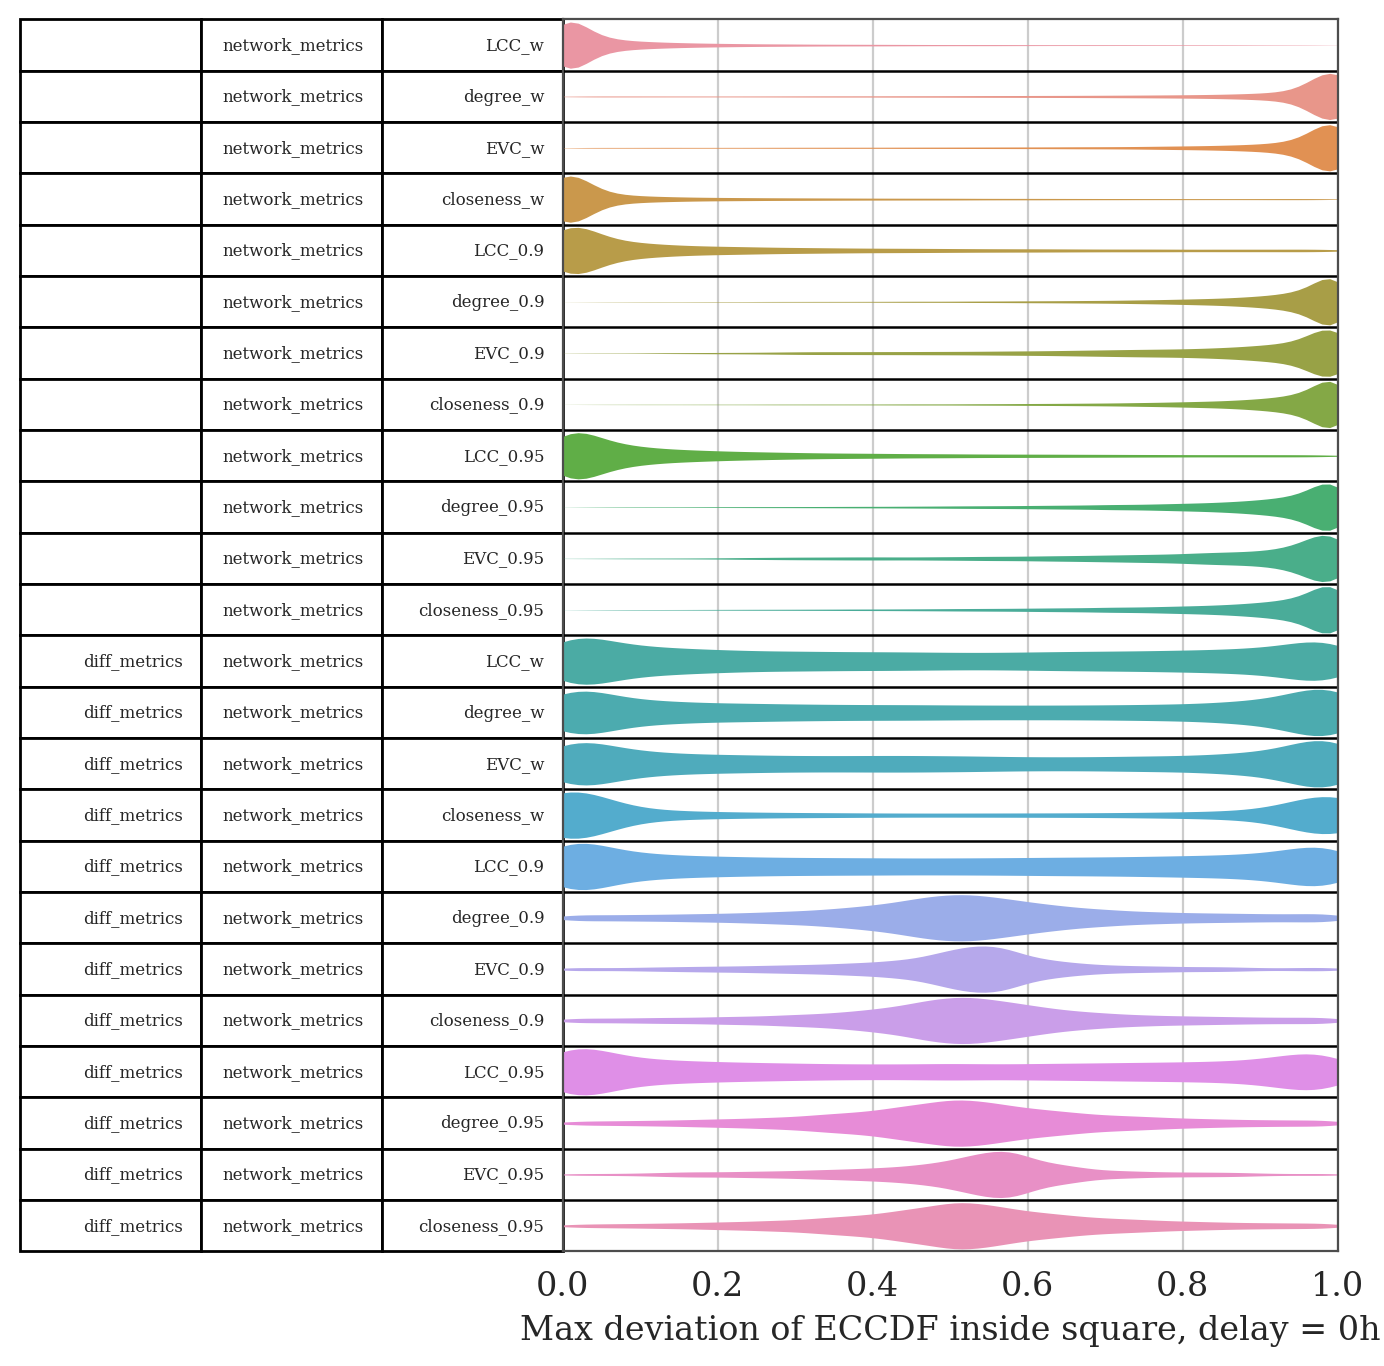

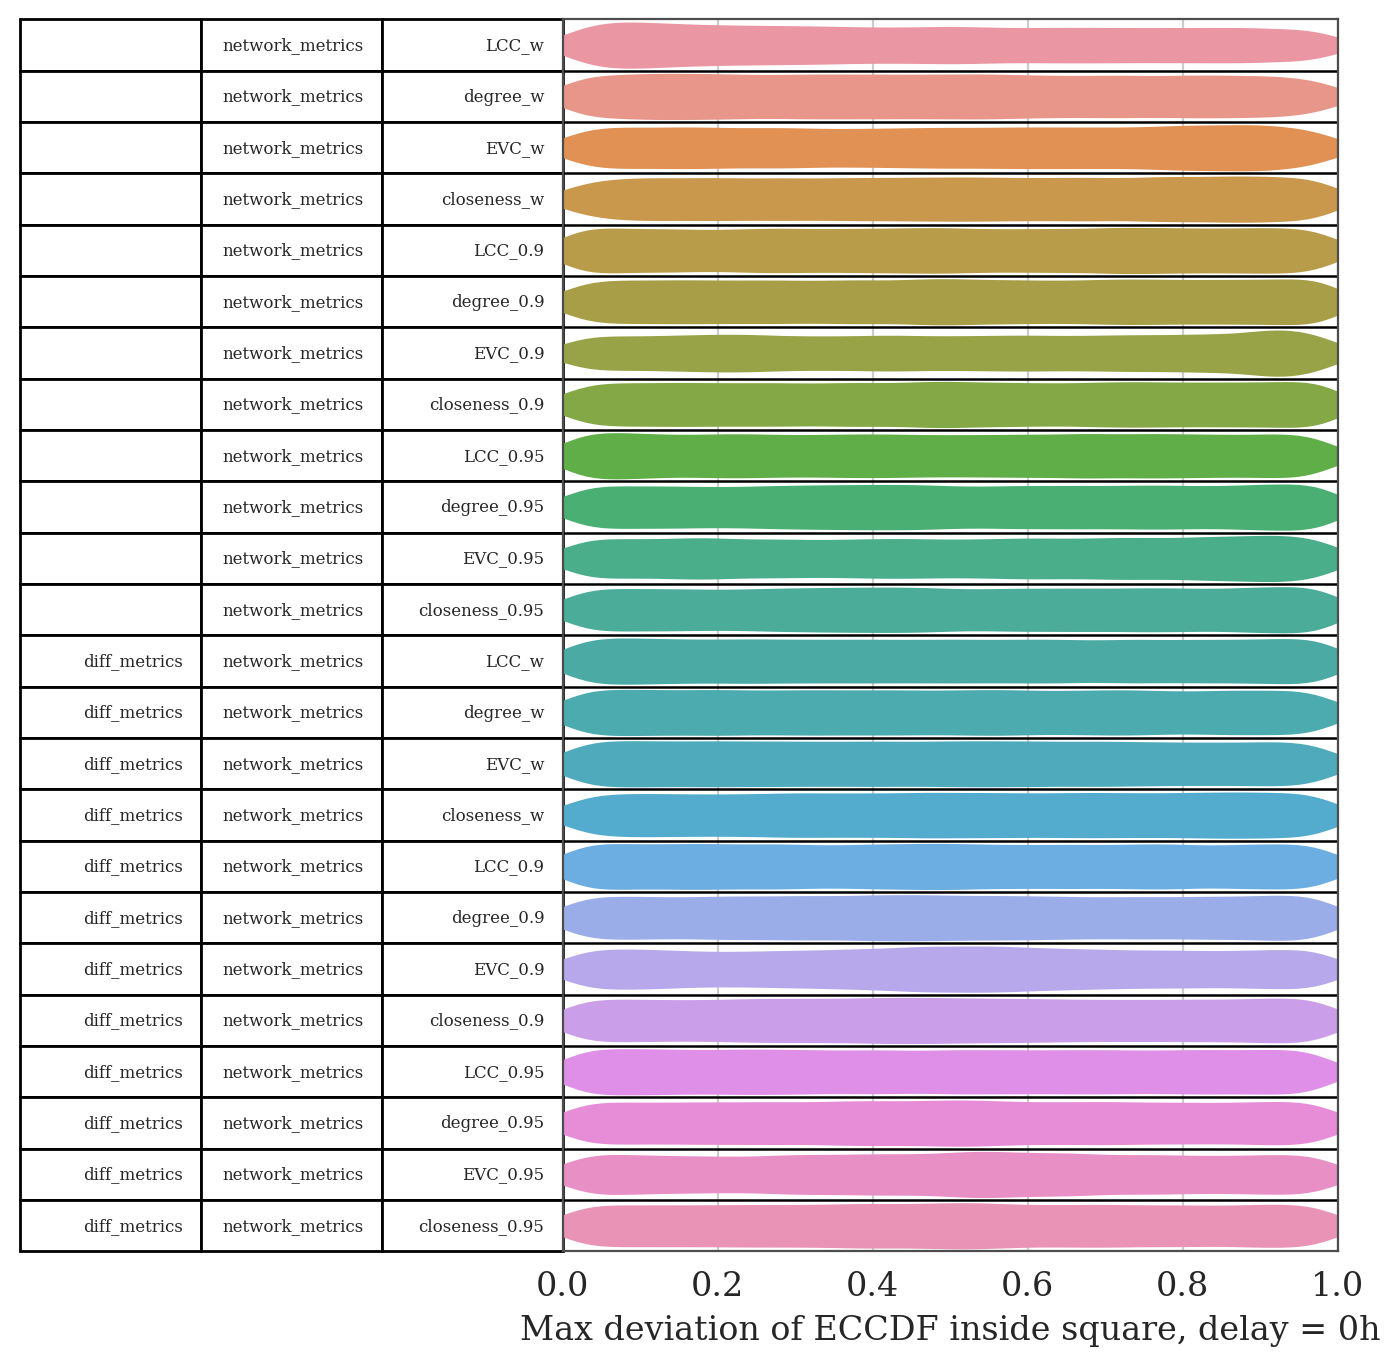

In [52]:
def plot_table_violinplot(cyclone_lgm_deviations_metric_values):
    plt.figure(figsize=(5, 8), dpi=200)
    deviation_metric_names = list(cyclone_lgm_deviations_metric_values.keys())
    #deviation_metric_names = ["     ".join(metric_name.split('/')[2:]) for metric_name in deviation_metric_names]
    start_index = 4 if is_sond else 3
    deviation_metric_names = [metric_name.split('/')[start_index:] for metric_name in deviation_metric_names]
    deviation_metric_names = [[''] * (3 - len(metric_name)) + metric_name for metric_name in deviation_metric_names]
    plt.table(deviation_metric_names, loc='left', bbox=(-0.7, 0, 0.7, 1))
    sns.violinplot(data=list(cyclone_lgm_deviations_metric_values.values()), orient='h', linewidth=0, width=0.9, cut=0, scale='width')
    for i in range(len(deviation_metric_names)):
        plt.plot([0, 1], [i + 0.5, i + 0.5], 'k', lw=0.9)
    plt.xlim([0, 1])
    plt.ylim([-0.5, len(deviation_metric_names)-0.5])
    plt.gca().invert_yaxis()
    plt.xlabel('Max deviation of ECCDF inside square, delay = ' + delay)
    plt.gca().set_yticklabels([])

for track_size in config.g_test_options['track_sizes']:
    cyclone_lgm_deviations_metric_values = load_cyclone_lgm_deviations(metric_names, track_size, is_sond=is_sond)
    cyclone_lgm_deviations_metric_values_unshifted = filter_shifted(cyclone_lgm_deviations_metric_values, is_shifted=False)
    plot_table_violinplot(cyclone_lgm_deviations_metric_values_unshifted)
    file_name = image_dir / (f'cyclone_lgm_deviations_boxplot_track_size_{track_size}.png')
    plt.savefig(file_name, bbox_inches='tight')

    cyclone_lgm_deviations_metric_values_shifted = filter_shifted(cyclone_lgm_deviations_metric_values, is_shifted=True)
    plot_table_violinplot(cyclone_lgm_deviations_metric_values_shifted)
    file_name = image_dir / (f'cyclone_lgm_shifted_deviations_boxplot_track_size_{track_size}.png')
    plt.savefig(file_name, bbox_inches='tight')

In [53]:
# Export cyclone lgm deviation
for track_size in config.g_test_options['track_sizes']:
    cyclone_lgm_deviations_metric_values = load_cyclone_lgm_deviations(metric_names, track_size, is_sond=is_sond)
    
    cyclone_lgm_deviations_metric_values_unshifted = filter_shifted(cyclone_lgm_deviations_metric_values, is_shifted=False)
    df_prob_metrics = pd.DataFrame.from_dict(cyclone_lgm_deviations_metric_values_unshifted, orient='index').T
    df_prob_metrics.to_csv(image_dir / f'lgm_metric_in_track_for_cyclones_track_size_{track_size}.csv')

    cyclone_lgm_deviations_metric_values_shifted = filter_shifted(cyclone_lgm_deviations_metric_values, is_shifted=True)
    df_prob_metrics = pd.DataFrame.from_dict(cyclone_lgm_deviations_metric_values_shifted, orient='index').T
    df_prob_metrics.to_csv(image_dir / f'lgm_shifted_metric_in_track_for_cyclones_track_size_{track_size}.csv')
    
    #df_prob_metrics.to_csv(image_dir / f'lgm_max_deviation_in_track_for_cyclones_track_size_{track_size}.csv')

2
4


In [19]:
image_dir

WindowsPath('Z:/Research/Climate/data/ERA5/ERA5_MSL_1982_2020_3h_0.75/results_histogram/metric_in_region_delay_0h_window_48h')